In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

import subtle.subtle_io as suio
import subtle.subtle_loss as suloss
import subtle.subtle_metrics as sumetrics
from subtle.dnn.generators import GeneratorUNet2D, GeneratorMultiRes2D
from subtle.data_loaders import SliceLoader
from tqdm import tqdm_notebook as tqdm

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None, titles=['Pre contrast', 'Low contrast', 'Full Contrast']):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title=titles[1], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title=titles[2], vmin=vmin, vmax=vmax)

    plt.show()

Using TensorFlow backend.
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
W1009 08:23:03.028551 140311365560128 deprecation_wrapper.py:119] From /home/srivathsa/projects/SubtleGad/subtle/subtle_loss.py:18: The name tf.log is deprecated. Please use tf.math.log instead.



In [13]:
fpath_h5 = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO26.h5'
ims = suio.load_file(fpath_h5)
data_zero, data_low, data_full = ims.transpose(1, 0, 2, 3)

In [25]:
ckp_file = '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/slices_single_swap.checkpoint'
data_loader = SliceLoader(
    data_list=[fpath_h5], batch_size=1, shuffle=False, verbose=1,
    slices_per_input=1, resize=240, slice_axis=[0], predict=True
)

loss_function = suloss.mixed_loss(l1_lambda=0.3, ssim_lambda=0.3)
metrics_monitor = [suloss.l1_loss, suloss.ssim_loss, suloss.mse_loss]
    
# model = GeneratorUNet2D(
#     num_channel_output=1, num_channel_first=32, num_poolings=3,
#     loss_function=loss_function, metrics_monitor=metrics_monitor,
#     batch_norm=False, verbose=1, checkpoint_file=ckp_file,
#     img_rows=240, img_cols=240, num_channel_input=14
# )

model = GeneratorMultiRes2D(
    num_channel_output=1, num_channel_first=32, num_poolings=3,
    loss_function=loss_function, metrics_monitor=metrics_monitor,
    batch_norm=False, verbose=1, checkpoint_file=ckp_file,
    img_rows=240, img_cols=240, num_channel_input=2
)

model.load_weights()

Building respath model...
Tensor("conv2d_318/BiasAdd:0", shape=(?, 240, 240, 1), dtype=float32)
loading weights from /home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/slices_single_swap.checkpoint


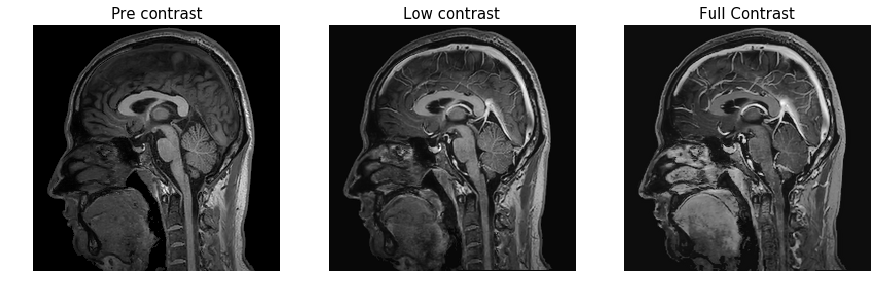

In [26]:
show_gad_comparison(data_zero[98], data_low[98], data_full[98])

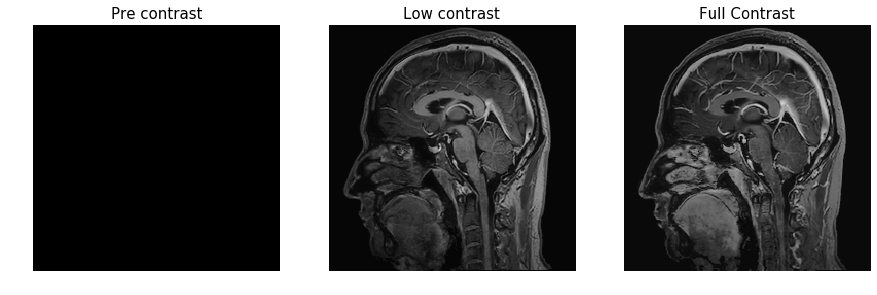

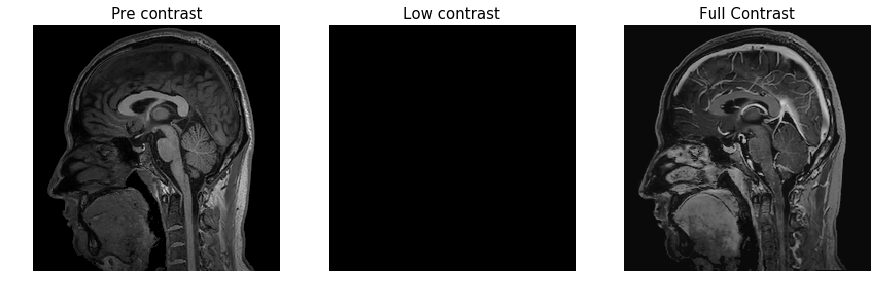

In [27]:
glen = data_loader.__len__()
# ims_mod = ims * 0.75

ims_mod_zero = np.copy(ims)
ims_mod_low = np.copy(ims)

# ims_mod_zero[:, 0] = np.random.normal(ims_mod_zero.min(), ims_mod_zero.max(), size=ims_mod_zero[:, 0].shape)
# ims_mod_low[:, 1] = np.random.normal(ims_mod_low.min(), ims_mod_low.max(), size=ims_mod_low[:, 0].shape)

ims_mod_zero[:, 0] = ims_mod_zero[:, 0] * 0
ims_mod_low[:, 1] = ims_mod_low[:, 1] * 0

show_gad_comparison(ims_mod_zero[98, 0], ims_mod_zero[98, 1], ims_mod_zero[98, 2], vmin=ims.min(), vmax=ims.max())
show_gad_comparison(ims_mod_low[98, 0], ims_mod_low[98, 1], ims_mod_low[98, 2], vmin=ims.min(), vmax=ims.max())

In [28]:
ypred = []
ypred_mod_zero = []
ypred_mod_low = []

for idx in tqdm(range(glen), total=glen):
    item = data_loader.__getitem__(idx, data_npy=ims)
    item_mod_zero = data_loader.__getitem__(idx, data_npy=ims_mod_zero)
    item_mod_low = data_loader.__getitem__(idx, data_npy=ims_mod_low)
    ypred.extend(model.model.predict(item, verbose=0))
    ypred_mod_zero.extend(model.model.predict(item_mod_zero, verbose=0))
    ypred_mod_low.extend(model.model.predict(item_mod_low, verbose=0))
ypred = np.array(ypred)
ypred_mod_zero = np.array(ypred_mod_zero)
ypred_mod_low = np.array(ypred_mod_low)

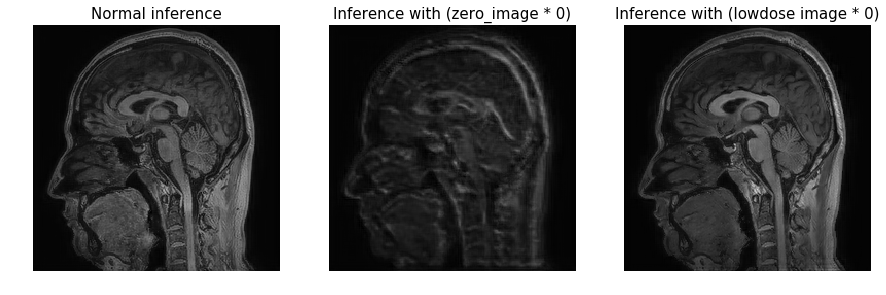

In [29]:
show_gad_comparison(
    ypred[98, ..., 0], ypred_mod_zero[98, ..., 0], ypred_mod_low[98, ..., 0], 
    vmin=ims.min(), vmax=ims.max(),
    titles=['Normal inference', 'Inference with (zero_image * 0)', 'Inference with (lowdose image * 0)']
)

### SSIM Comparison

Predicting for scale 0.0



Predicting for scale 0.1



Predicting for scale 0.2



Predicting for scale 0.30000000000000004



Predicting for scale 0.4



Predicting for scale 0.5



Predicting for scale 0.6000000000000001



Predicting for scale 0.7000000000000001



Predicting for scale 0.8



Predicting for scale 0.9



Predicting for scale 1.0


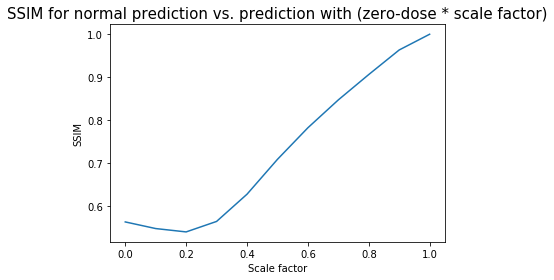

In [30]:
mod_preds = []

for sf in np.linspace(0, 1, 11):
    print('Predicting for scale {}'.format(sf))
    ims_mod_zero = np.copy(ims)
    ims_mod_zero[:, 0] *= sf
    
    ypred_mod = []
    for idx in tqdm(range(glen), total=glen):
        item_mod = data_loader.__getitem__(idx, data_npy=ims_mod_zero)
        ypred_mod.extend(model.model.predict(item_mod, verbose=0))
    ypred_mod = np.array(ypred_mod)
    mod_preds.append(ypred_mod)
mod_preds = np.array(mod_preds)

ssims = []

for pred in range(mod_preds.shape[0]):
    ssims.append(sumetrics.ssim(ypred[98, ..., 0], mod_preds[pred, 98, ..., 0]))

plt.plot(np.linspace(0, 1, 11), ssims)
plt.xlabel('Scale factor')
plt.ylabel('SSIM')
plt.title('SSIM for normal prediction vs. prediction with (zero-dose * scale factor)', fontsize=15)
plt.show()